In [ ]:
import ee
import numpy as np
import folium
import geopandas as gpd
import json
from util import get_whole_region

try:     
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [119]:
startDate = '2017-01-01';
endDate = '2021-01-01';
shp_file = gpd.read_file('/home/graham/Downloads/RFCx_GQ_Shapefiles/Hulu_Batang_Hari_sites_Buffer1k.shp', crs='EPSG:4326')
region = get_whole_region(shp_file)
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(startDate, endDate).filterBounds(region);

probabilityBands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
];

dwTimeSeries = dw.select(probabilityBands)


In [72]:
from geetools import tools

data = tools.imagecollection.getValues(
    collection=dwTimeSeries,
    geometry=region,
    reducer='mode',
    scale=10,
    maxPixels=1e9,
    side='client',
    bestEffort=True)
data

{'20200124T134639_20200124T134636_T22MCA': {'bare': 0.0341243587523051,
  'built': 0.032810026767489946,
  'crops': 0.029946609869433774,
  'flooded_vegetation': 0.026843899353121363,
  'grass': 0.03322914235773928,
  'shrub_and_scrub': 0.03325333147069617,
  'snow_and_ice': 0.03310859972094263,
  'trees': 0.7441844211259461,
  'water': 0.030313947117055234},
 '20200228T135111_20200228T135107_T22MDB': {'bare': 0.03613434645243657,
  'built': 0.030752956314538,
  'crops': 0.02977475994210305,
  'flooded_vegetation': 0.029804287777705527,
  'grass': 0.03341055387524117,
  'shrub_and_scrub': 0.034217724051915296,
  'snow_and_ice': 0.033591008996065236,
  'trees': 0.7363534508797454,
  'water': 0.032968254570833785},
 '20200228T135111_20200228T135107_T22MFC': {'bare': 0.0341980632058212,
  'built': 0.028075625258099514,
  'crops': 0.028740216183508333,
  'flooded_vegetation': 0.0327196942136539,
  'grass': 0.03175641021504861,
  'shrub_and_scrub': 0.036090631445410776,
  'snow_and_ice': 0.

In [89]:
x = tools.imagecollection.data2pandas(data)
x = x.reset_index()
x = x.dropna()

In [90]:
x['index'] = x['index'].apply(lambda x: x.split("_")[0][0:8])

In [91]:
x

,index,bare,built,crops,flooded_vegetation,grass,shrub_and_scrub,snow_and_ice,trees,water
0,20200124,0.034124,0.032810,0.029947,0.026844,0.033229,0.033253,0.033109,0.744184,0.030314
1,20200228,0.036134,0.030753,0.029775,0.029804,0.033411,0.034218,0.033591,0.736353,0.032968
2,20200228,0.034198,0.028076,0.028740,0.032720,0.031756,0.036091,0.033205,0.740232,0.034161
3,20200316,0.036109,0.033201,0.029637,0.027846,0.033531,0.033372,0.033295,0.740192,0.030348
5,20200326,0.036172,0.029420,0.029651,0.034669,0.036930,0.034216,0.033790,0.728499,0.036143
...,...,...,...,...,...,...,...,...,...,...
268,20201211,0.036065,0.033281,0.030013,0.030105,0.033787,0.033431,0.033539,0.736307,0.032493
269,20201211,0.035653,0.032303,0.030340,0.030073,0.033972,0.033498,0.033563,0.736279,0.032459
270,20201214,0.033707,0.027834,0.030362,0.032720,0.034077,0.032183,0.036187,0.740241,0.033655
271,20201219,0.032259,0.030185,0.032076,0.031985,0.032719,0.029400,0.036059,0.740371,0.034165


/home/graham/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/graham/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='index', ylabel='trees'>

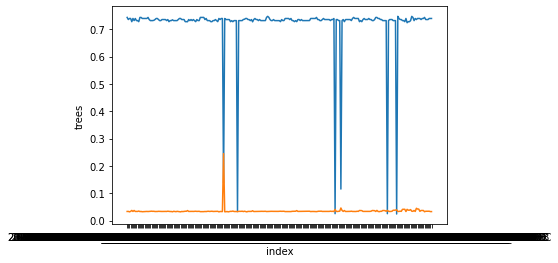

In [83]:
import seaborn as sns

sns.lineplot(x['index'],x['trees'])
sns.lineplot(x['index'],x['grass'])

In [120]:
reduced = tools.imagecollection.reduceEqualInterval(dwTimeSeries,interval=1,unit='month',reducer='mode')


{'type': 'ImageCollection',
 'bands': [],
 'features': [{'type': 'Image',
   'bands': [{'id': 'water',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'trees',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'grass',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'flooded_vegetation',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'crops',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'shrub_and_scrub',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1,

In [122]:
reduced_data = tools.imagecollection.getValues(
    collection=reduced,
    geometry=region,
        reducer='mode',
        scale=100,
    maxPixels=1e9,
    side='client',
    bestEffort=True)

In [123]:
x = tools.imagecollection.data2pandas(reduced_data)
x = x.reset_index()

In [124]:
x = x.melt('index',var_name='bands',value_name='values')


In [125]:
x = x.sort_values(by=['index'])

In [126]:
x['index'] = int(x['index'])

,index,bands,values
0,0,bare,NaN
235,0,shrub_and_scrub,NaN
282,0,snow_and_ice,NaN
376,0,water,NaN
47,0,built,NaN
...,...,...,...
140,9,crops,0.032905
375,9,trees,0.744159
46,9,bare,0.026598
187,9,flooded_vegetation,0.029793


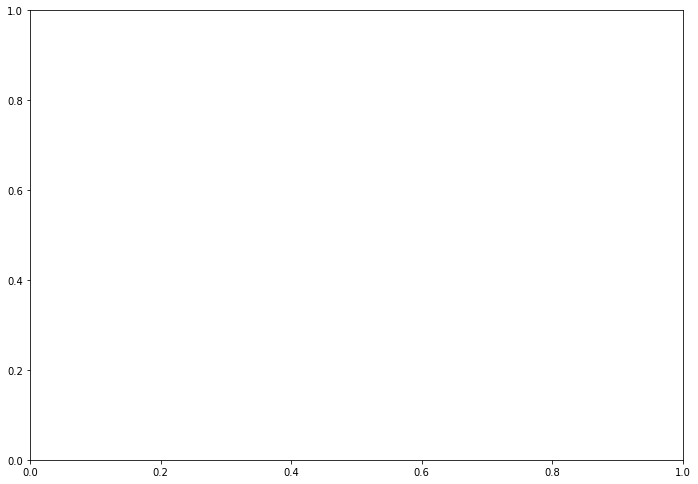

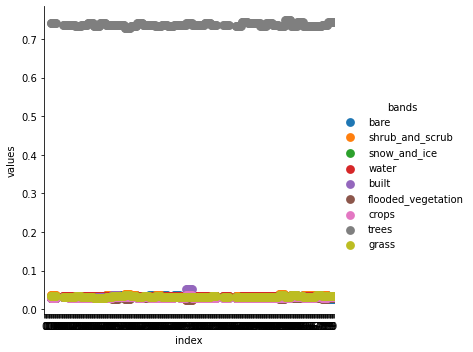

In [131]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
sns.catplot(x='index',y='values',hue='bands',data=x,kind='point')
